In [11]:
# =========== IMPORT LIBRARIES ============
import keras_tuner as kt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
import itertools 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")


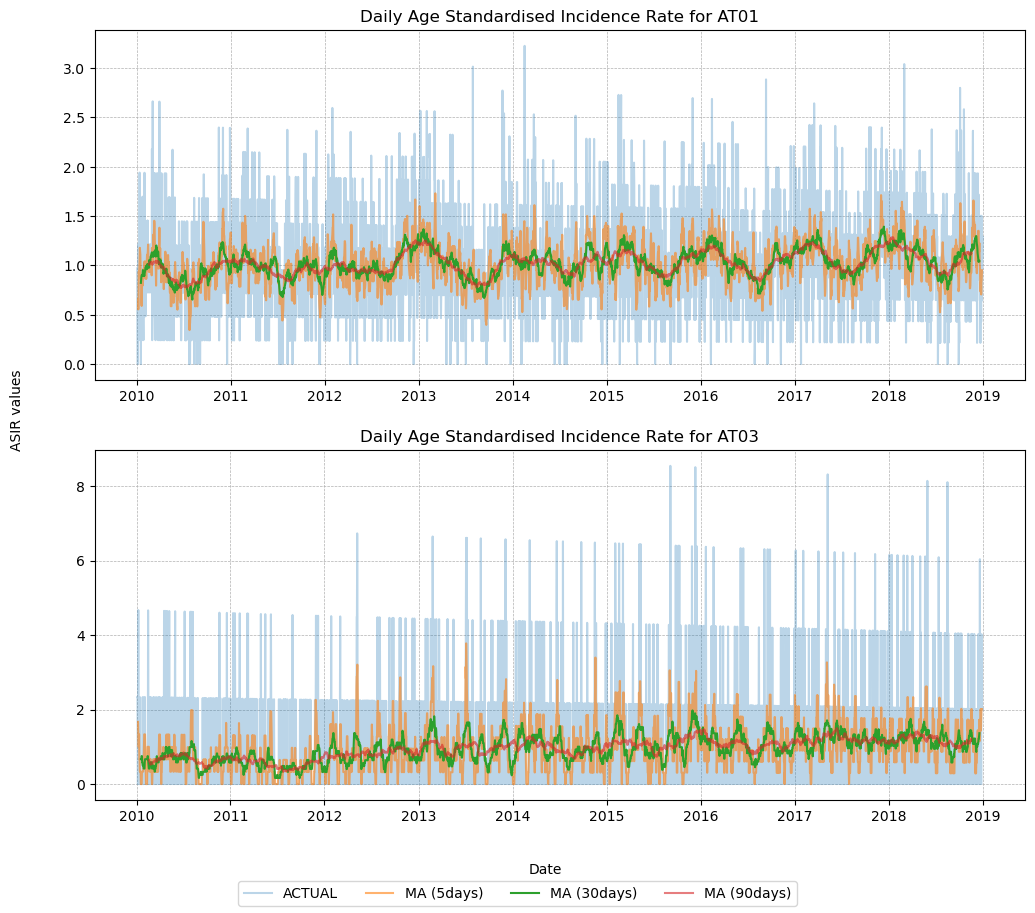

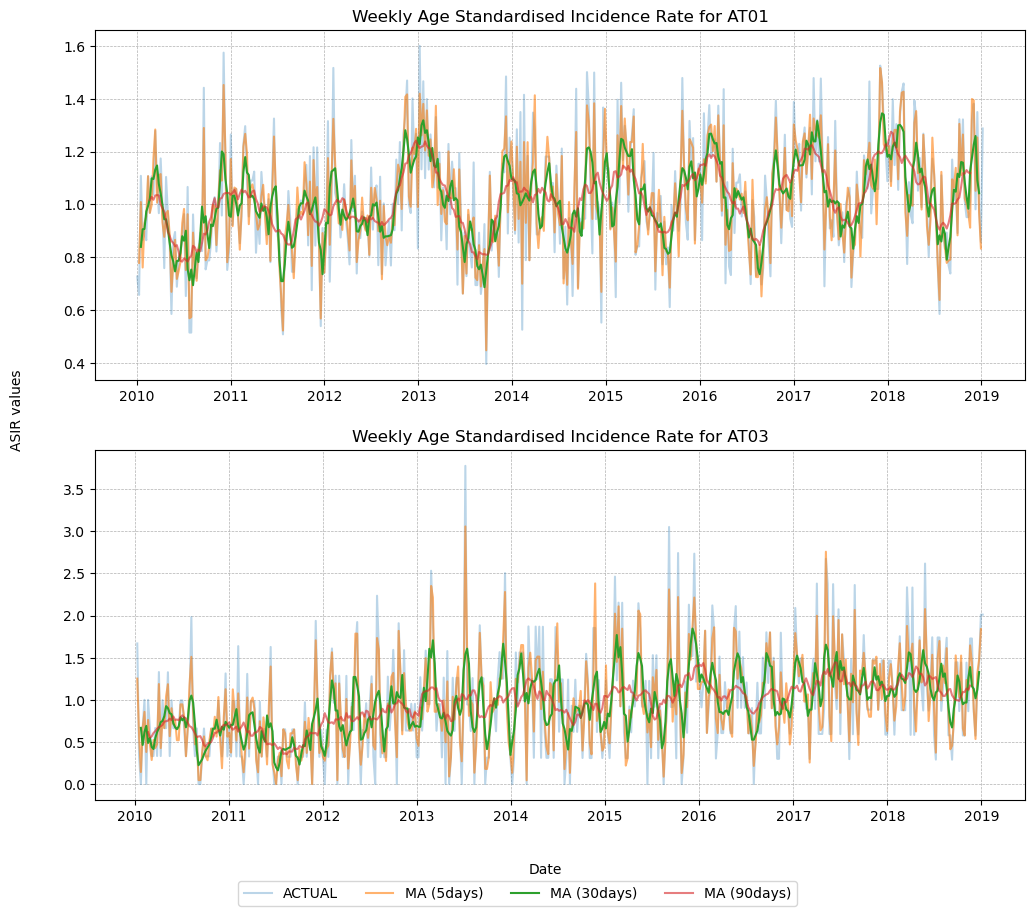

In [12]:
data = pd.read_csv('modelling_data/data.csv')
data.date = pd.to_datetime(data.date)
# Filter data for AT01 and AT03
data_at01 = data[data['at_code'] == 'AT01']
data_at03 = data[data['at_code'] == 'AT03']

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False, sharey=False)

# Subplot for AT01
axes[0].plot(data_at01['date'], data_at01['asir'], label='ACTUAL', alpha=0.3)
axes[0].plot(data_at01['date'], data_at01['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[0].plot(data_at01['date'], data_at01['b_asir_30'], label='MA (30days)', alpha=1)
axes[0].plot(data_at01['date'], data_at01['a_asir_90'], label='MA (90days)', alpha=0.6)
#axes[0].plot(data_at01['date'], data_at01['b_asir_365'], label='asir_365', alpha=0.6)
axes[0].set_title('Daily Age Standardised Incidence Rate for AT01')

# Subplot for AT02
axes[1].plot(data_at03['date'], data_at03['asir'], label='ACTUAL', alpha=0.3)
axes[1].plot(data_at03['date'], data_at03['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[1].plot(data_at03['date'], data_at03['b_asir_30'], label='MA (30days)', alpha=1)
axes[1].plot(data_at03['date'], data_at03['a_asir_90'], label='MA (90days)', alpha=0.6)
#axes[1].plot(data_at03['date'], data_at03['b_asir_365'], label='asir_365', alpha=0.6)
axes[1].set_title('Daily Age Standardised Incidence Rate for AT03')
axes[1].grid(True)

# Set x-axis to show every second year
for ax in axes:
    ax.xaxis.set_major_locator(YearLocator(1))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.grid(which='major', linestyle='--', linewidth=0.5)  # Minor grid style


# Create a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)

# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'ASIR values', ha='center', va='center', rotation='vertical')

# Save the plot as a PDF file
plt.savefig('../plots/asir_plots_daily.pdf', format='pdf', bbox_inches='tight')
plt.show()
# Filter data for AT01 and AT03
data_at01 = data[data['at_code'] == 'AT01'][['date', 'max_hum', 'min_hum', 'max_temp', 'min_temp','a_asir_90', 'b_asir_365', 'c_asir_5', 'b_asir_30', 'asir', 'is_holiday', 'mean_O3', 'mean_PM10']]
data_at03 = data[data['at_code'] == 'AT03'][['date', 'max_hum', 'min_hum', 'max_temp', 'min_temp','a_asir_90', 'b_asir_365', 'c_asir_5', 'b_asir_30', 'asir', 'is_holiday', 'mean_O3', 'mean_PM10']]

# Define custom aggregation functions
custom_agg_functions = {
    'max_hum': 'max',
    'min_hum': 'min',
    'max_temp': 'max',
    'min_temp': 'min',
    'a_asir_90': 'mean',
    'b_asir_365': 'mean',
    'c_asir_5': 'mean',
    'b_asir_30': 'mean',
    'asir': 'mean',
    'is_holiday': 'max',
    'mean_O3' : 'mean',
    'mean_PM10' : 'mean'
}

# Aggregate data to weekly values
data_at01_weekly = data_at01.resample('W', on='date').agg(custom_agg_functions)
data_at03_weekly = data_at03.resample('W', on='date').agg(custom_agg_functions)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False, sharey=False)

# Subplot for AT01
axes[0].plot(data_at01_weekly.index, data_at01_weekly['asir'], label='ACTUAL', alpha=0.3)
axes[0].plot(data_at01_weekly.index, data_at01_weekly['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[0].plot(data_at01_weekly.index, data_at01_weekly['b_asir_30'], label='MA (30days)', alpha=1)
axes[0].plot(data_at01_weekly.index, data_at01_weekly['a_asir_90'], label='MA (90days)', alpha=0.6)
axes[0].set_title('Weekly Age Standardised Incidence Rate for AT01')

# Subplot for AT02
axes[1].plot(data_at03_weekly.index, data_at03_weekly['asir'], label='ACTUAL', alpha=0.3)
axes[1].plot(data_at03_weekly.index, data_at03_weekly['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[1].plot(data_at03_weekly.index, data_at03_weekly['b_asir_30'], label='MA (30days)', alpha=1)
axes[1].plot(data_at03_weekly.index, data_at03_weekly['a_asir_90'], label='MA (90days)', alpha=0.6)
axes[1].set_title('Weekly Age Standardised Incidence Rate for AT03')
axes[1].grid(True)

# Set x-axis to show every second year
for ax in axes:
    ax.xaxis.set_major_locator(YearLocator(1))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.grid(which='major', linestyle='--', linewidth=0.5)  # Minor grid style

# Create a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)

# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'ASIR values', ha='center', va='center', rotation='vertical')

# Save the plot as a PDF file
plt.savefig('../plots/asir_plots_weekly.pdf', format='pdf', bbox_inches='tight')
plt.show()

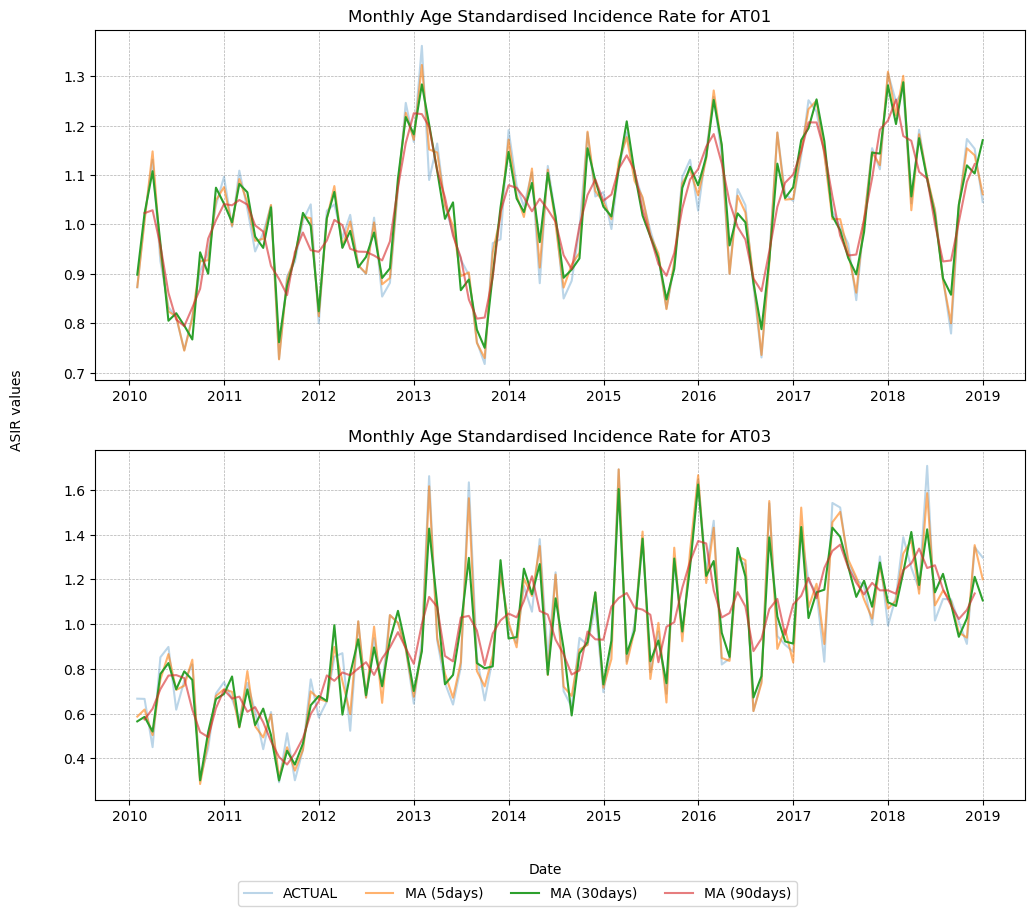

In [13]:
# Aggregate data to monthly values
data_at01_monthly = data_at01.resample('M', on='date').agg(custom_agg_functions)
data_at03_monthly = data_at03.resample('M', on='date').agg(custom_agg_functions)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False, sharey=False)

# Subplot for AT01
axes[0].plot(data_at01_monthly.index, data_at01_monthly['asir'], label='ACTUAL', alpha=0.3)
axes[0].plot(data_at01_monthly.index, data_at01_monthly['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[0].plot(data_at01_monthly.index, data_at01_monthly['b_asir_30'], label='MA (30days)', alpha=1)
axes[0].plot(data_at01_monthly.index, data_at01_monthly['a_asir_90'], label='MA (90days)', alpha=0.6)
axes[0].set_title('Monthly Age Standardised Incidence Rate for AT01')

# Subplot for AT02
axes[1].plot(data_at03_monthly.index, data_at03_monthly['asir'], label='ACTUAL', alpha=0.3)
axes[1].plot(data_at03_monthly.index, data_at03_monthly['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[1].plot(data_at03_monthly.index, data_at03_monthly['b_asir_30'], label='MA (30days)', alpha=1)
axes[1].plot(data_at03_monthly.index, data_at03_monthly['a_asir_90'], label='MA (90days)', alpha=0.6)
axes[1].set_title('Monthly Age Standardised Incidence Rate for AT03')
axes[1].grid(True)

# Set x-axis to show every second year
for ax in axes:
    ax.xaxis.set_major_locator(YearLocator(1))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.grid(which='major', linestyle='--', linewidth=0.5)  # Minor grid style

# Create a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)

# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'ASIR values', ha='center', va='center', rotation='vertical')

# Save the plot as a PDF file
plt.savefig('../plots/asir_plots_monthly.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [14]:
# Decompose the time series
def decompose(Y, at, data):
    if data == "monthly":
        decomposition = seasonal_decompose(Y, model='additive', period=12) #Assuming monthly periodicity

        # Plot the decomposition
        plt.figure(figsize=(12, 8))

        plt.subplot(4, 1, 1)
        plt.plot(decomposition.trend, label='Trend')
        plt.title(f'Trend Component - {at}')
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(decomposition.seasonal, label='Seasonal')
        plt.title(f'Seasonal Component - {at}')
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(decomposition.resid, label='Residual')
        plt.title(f'Residual Component - {at}')
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(Y, label='Original')
        plt.title(f'Original Time Series - {at}')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        decomposition = seasonal_decompose(Y, model='additive', period=52) #Assuming monthly periodicity

        # Plot the decomposition
        plt.figure(figsize=(12, 8))

        plt.subplot(4, 1, 1)
        plt.plot(decomposition.trend, label='Trend')
        plt.title(f'Trend Component - {at}')
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(decomposition.seasonal, label='Seasonal')
        plt.title(f'Seasonal Component - {at}')
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(decomposition.resid, label='Residual')
        plt.title(f'Residual Component - {at}')
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(Y, label='Original')
        plt.title(f'Original Time Series - {at}')
        plt.legend()

        plt.tight_layout()
        plt.show()



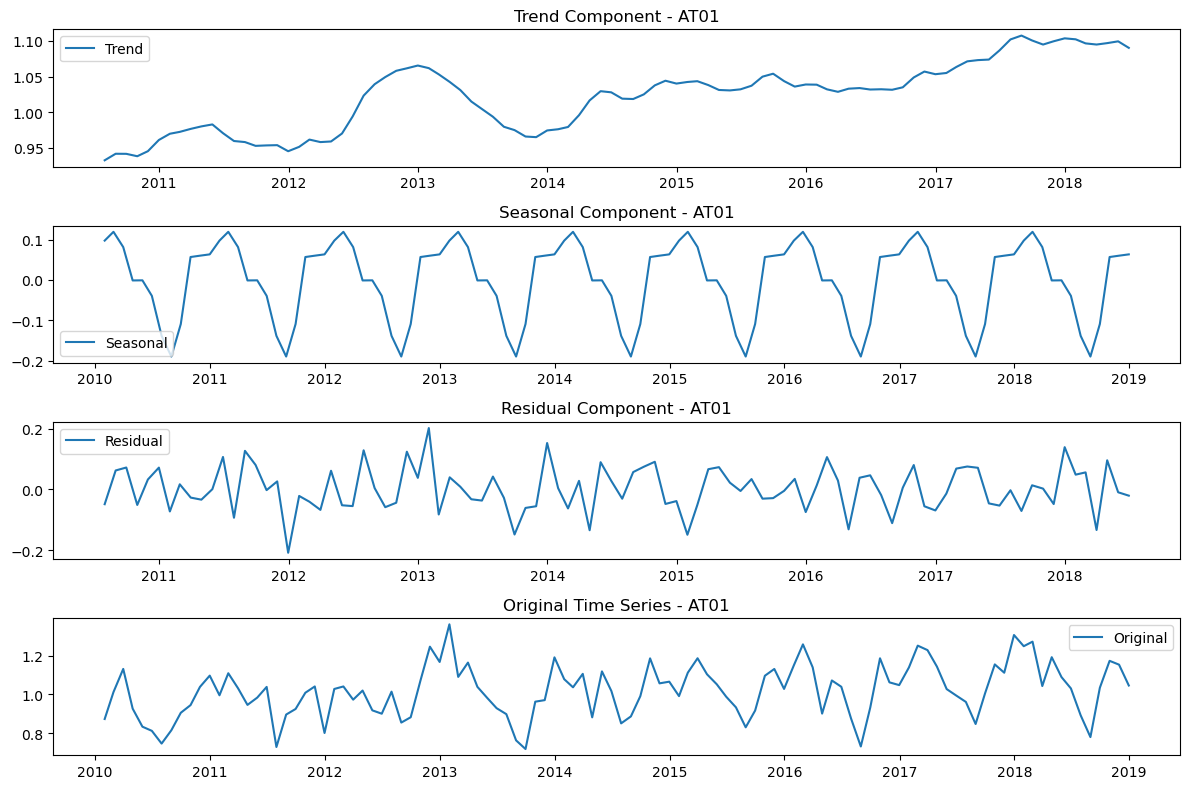

In [15]:
# ASIR WEEKLY (DAILY IS TOO NOISY)

decompose(data_at01_monthly['asir'],"AT01","monthly")
#decompose(data_at01_weekly['asir'],"AT01","weekly")
#decompose(data_at03_monthly['asir'],"AT03","monthly")
#decompose(data_at03_weekly['asir'],"AT03","weekly")


In [16]:
#DATASETS
#data_at01_weekly, data_at03_weekly, data_at01_monthly ,data_at03_monthly

# WEEKLY

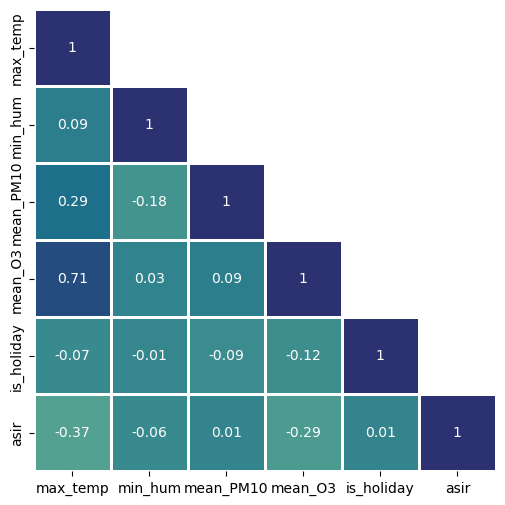

In [17]:
Y = data_at01_weekly[['asir']]
X = data_at01_weekly[['max_temp', 'min_hum', 'mean_PM10', 'mean_O3', 'is_holiday']]

# =========== SCALING ============
# Store the original index before scaling
original_index = Y.index

# Separate the features and the target
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(X)

# Scale the target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(Y)

# Create scaled DataFrame for train/test split
df_f_scaled = pd.DataFrame(scaled_features, index=original_index, columns=X.columns)
df_f_scaled['asir'] = scaled_target

# =========== BIVARIATE CORRELATION MATRIX ===========
def corrMat(df):
    
    # Calculate the correlation matrix
    corr_mat = df.corr().round(2)
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    np.fill_diagonal(mask, False)
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 6))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_mat, mask=mask, vmin=-1, vmax=1, center=0, 
                cmap='crest', square=True, linewidths=2, annot=True, cbar=False,
                xticklabels = True, yticklabels=True)
    
    # Display the heatmap
    plt.show()
    
corrMat(df_f_scaled)

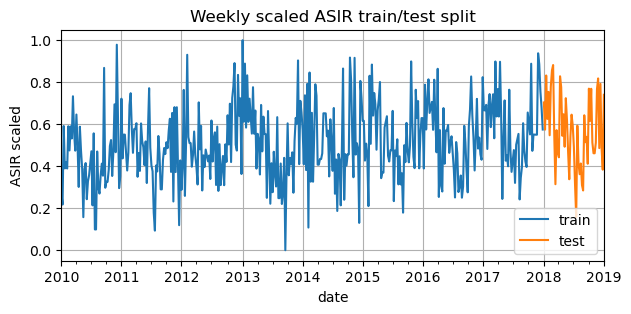

In [18]:
# =========== TRAIN/TEST SPLIT ============
# Filter the data for the year 2018
train = df_f_scaled[df_f_scaled.index.year < 2018]

# Filter the data from the year 2019 onwards
validation = df_f_scaled[df_f_scaled.index.year >= 2018]

# Plot
fig, ax = plt.subplots(figsize=(7, 3))
train['asir'].plot(ax=ax, label='train')  # Plot the 'asir' column of the training set
validation['asir'].plot(ax=ax, label='test')  # Plot the 'asir' column of the validation set
ax.set_title('Weekly scaled ASIR train/test split')
ax.legend()
plt.grid(True)
plt.ylabel('ASIR scaled')
plt.savefig('plots/train_test_scaled_split.pdf', format='pdf', bbox_inches='tight')
plt.show()

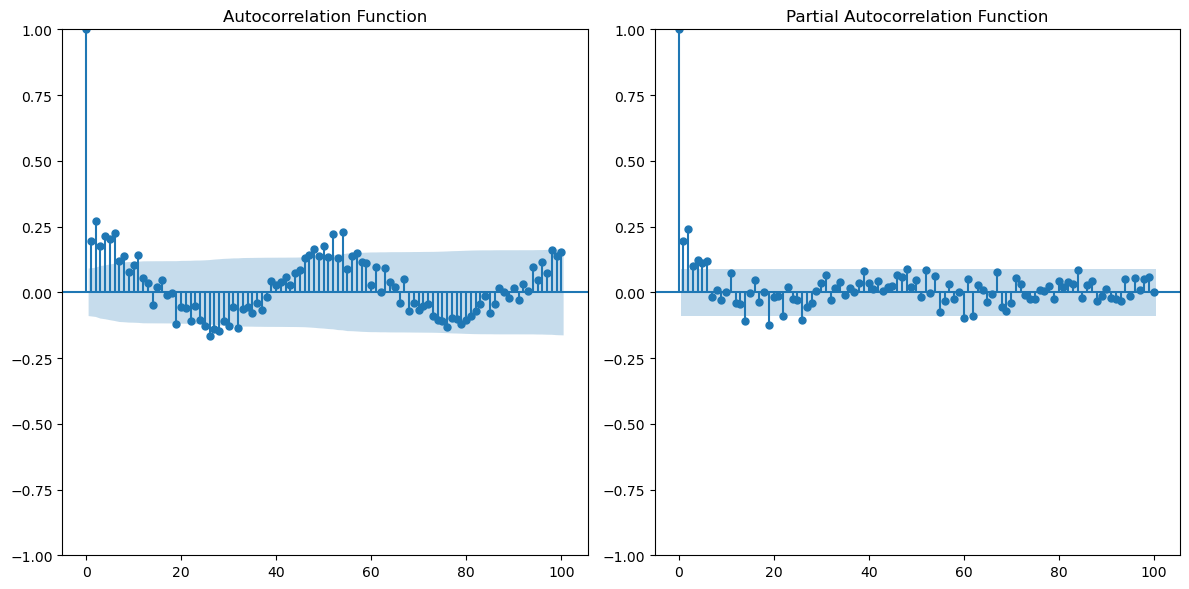

In [19]:

# # =========== STATIONARITY CHECK ============
# from statsmodels.tsa.stattools import adfuller
# dftest = adfuller(df_f_scaled.asir, autolag='AIC')
# print("Test statistic = {:.3f}".format(dftest[0]))
# print("P-value = {:.3f}".format(dftest[1]))
# print("Critical values :")
# for k, v in dftest[4].items():
#     print("\t{}: {} - The data is {}stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
# # =========== PLOT ACF AND PACF OF TARGET ============
# Plot ACF and PACF of target
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(df_f_scaled['asir'], ax=plt.gca(), lags=100)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(df_f_scaled['asir'], ax=plt.gca(), lags=100)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.savefig('plots/acf_pacf.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, p=1, d=1, q=1, P=1, D=1, Q=1, s=12):
        self.p = p
        self.d = d
        self.q = q
        self.P = P
        self.D = D
        self.Q = Q
        self.s = s
        self.model_ = None

    def fit(self, X, y=None):
        self.model_ = SARIMAX(endog=y, exog=X, order=(self.p, self.d, self.q),
                              seasonal_order=(self.P, self.D, self.Q, self.s)).fit(disp=False)
        return self

    def predict(self, X):
        return self.model_.forecast(steps=len(X), exog=X)

    def score(self, X, y):
        predictions = self.predict(X)
        return -np.mean((predictions - y) ** 2)  # negative MSE

# Define the parameter grid
p_values = list(range(0, 3))
d_values = list(range(0, 2))
q_values = list(range(0, 3))
P_values = list(range(0, 2))
D_values = list(range(0, 2))
Q_values = list(range(0, 3))
s_values = [52]

param_grid = [{
    'p': p,
    'd': d,
    'q': q,
    'P': P,
    'D': D,
    'Q': Q,
    's': s
} for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values)]

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=3)

X = train[['max_temp', 'min_hum', 'mean_PM10', 'mean_O3', 'is_holiday']]
y = train['asir']

# Perform grid search manually with progress bar
best_score = float('-inf')
best_params = None
results = []

total_iterations = len(param_grid) * tscv.get_n_splits(X, y)

with tqdm(total=total_iterations, desc="GridSearchCV") as pbar:
    for params in param_grid:
        cv_scores = []
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model = SARIMAXWrapper(**params)
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            cv_scores.append(score)
            pbar.update(1)

        mean_cv_score = np.mean(cv_scores)
        results.append({
            **params,
            'score': mean_cv_score
        })

        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = params

print("Best parameters:", best_params)
# Store the results in a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('sarimax_tuning/grid_search_results.csv', index=False)
print("Grid search results saved to 'sarimax_tuning/grid_search_results.csv'")


GridSearchCV:  83%|████████▎ | 539/648 [3:17:35<39:57, 22.00s/it]    


KeyboardInterrupt: 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.35074D-01    |proj g|=  3.25670D-01

At iterate    5    f= -3.61234D-01    |proj g|=  6.86967D-01

At iterate   10    f= -3.76137D-01    |proj g|=  3.45625D-01

At iterate   15    f= -3.98816D-01    |proj g|=  8.51143D-02

At iterate   20    f= -4.07773D-01    |proj g|=  1.84428D-01

At iterate   25    f= -4.13136D-01    |proj g|=  3.99029D-02

At iterate   30    f= -4.13339D-01    |proj g|=  2.79946D-03

At iterate   35    f= -4.13348D-01    |proj g|=  1.74474D-03

At iterate   40    f= -4.13348D-01    |proj g|=  4.97650D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

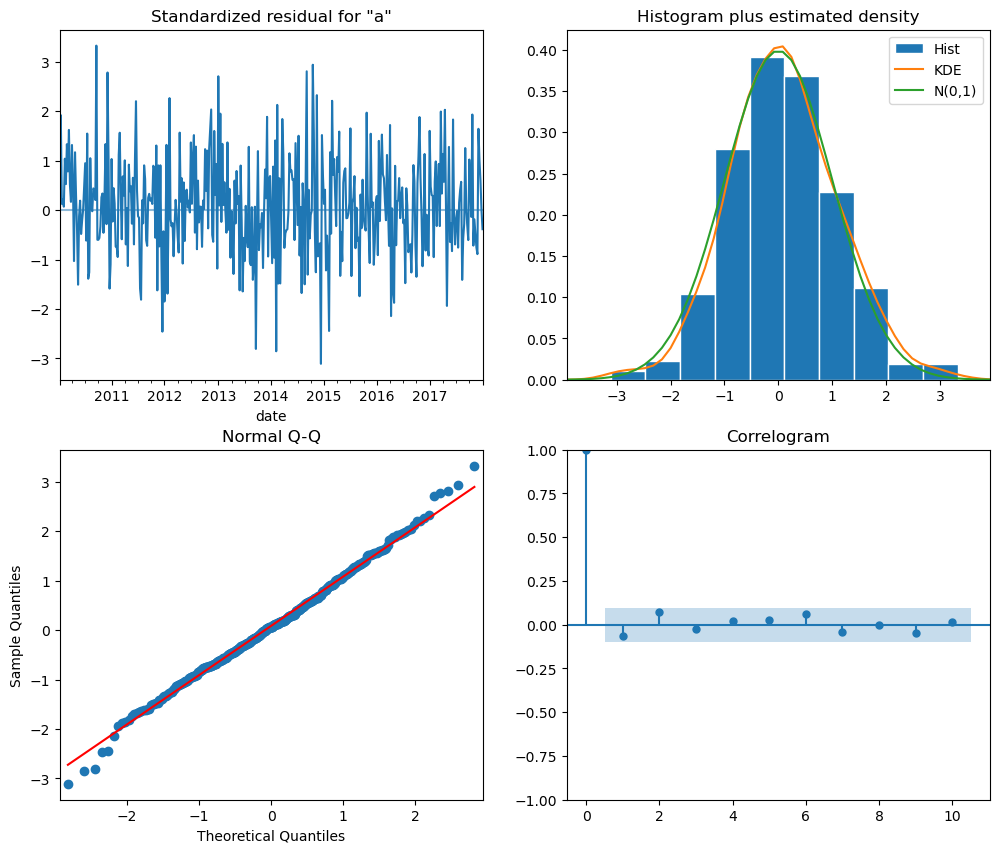

In [22]:
order = (0, 1, 1)  # ARIMA order
seasonal_order = (0, 0, 1, 52)  # Seasonal order

# Fit the SARIMAX model
model = SARIMAX(train['asir'], order = order, seasonal_order = seasonal_order, exog = train[['max_temp', 'min_hum', 'mean_PM10', 'mean_O3', 'is_holiday']])
results = model.fit()

# Print the model summary
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(12, 10))
plt.savefig('plots/residuals_diag_sarimax.pdf', format='pdf', bbox_inches='tight')
plt.show()

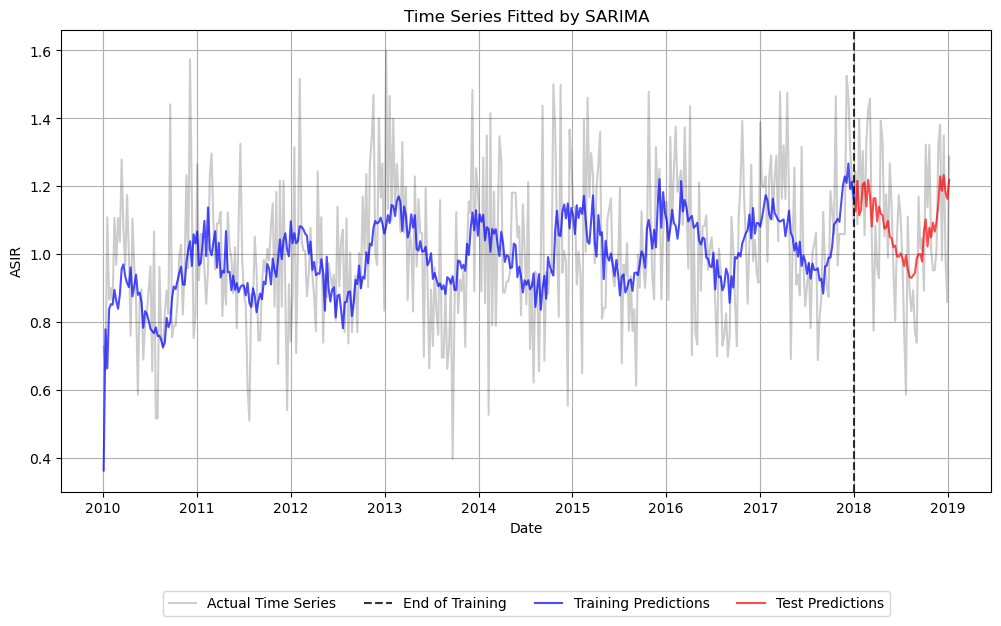

In [23]:
# Make predictions for training data
train_forecast = results.get_prediction(start=train.index[0], end=train.index[-1], exog=train[['max_temp', 'min_hum', 'mean_PM10', 'mean_O3', 'is_holiday']])
train_forecast_values = train_forecast.predicted_mean
train_forecast_values_original_scale = target_scaler.inverse_transform(train_forecast_values.values.reshape(-1, 1))

# Make predictions for validation data
forecast = results.get_forecast(steps=len(validation), exog=validation[['max_temp', 'min_hum', 'mean_PM10', 'mean_O3', 'is_holiday']])
forecast_values = forecast.predicted_mean
forecast_values_original_scale = target_scaler.inverse_transform(forecast_values.values.reshape(-1, 1))

# Plot actual data
plt.figure(figsize=(12, 6))
plt.plot(data_at01_weekly.index, data_at01_weekly['asir'], label='Actual Time Series', color='black', alpha=0.2)

# Add vertical line at the end of train
plt.axvline(train.index[-1], color='k', linestyle='--', label='End of Training', alpha=0.8)

# Plot forecasted values for training data
plt.plot(train_forecast_values.index, train_forecast_values_original_scale, label='Training Predictions', color='blue', alpha=0.7)

# Plot forecasted values for validation data
plt.plot(forecast_values.index, forecast_values_original_scale, label='Test Predictions', color='red', alpha=0.7)

# Specify any additional plot settings
plt.xlabel('Date')
plt.ylabel('ASIR')
plt.title('Time Series Fitted by SARIMA')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)  # ncol sets the number of columns in the legend
plt.savefig('plots/sarima_forecast.pdf', format='pdf', bbox_inches='tight')
# Show plot
plt.show()

In [24]:
# # Plot residuals
# residuals = results.resid
# plt.figure(figsize=(10, 6))
# plt.plot(train.index, residuals, color='green')
# plt.title('Residuals Plot')
# plt.xlabel('Date')
# plt.ylabel('Residuals')
# plt.grid(True)
# plt.show()

# Calculate evaluation metrics
mae = mean_absolute_error(validation['asir'], forecast_values)
mse = mean_squared_error(validation['asir'], forecast_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((validation['asir'] - forecast_values) / validation['asir'])) * 100

# Create a DataFrame
compare = pd.DataFrame({
    'values': ['MAE', 'MSE', 'RMSE', 'MAPE', 'AIC', 'BIC'],
    'sarima': [mae, mse, rmse, mape, results.aic, results.bic]
})

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Akaike Information Criterion (AIC):", results.aic)
print("Bayesian Information Criterion (BIC):", results.bic)

Mean Absolute Error (MAE): 0.12481504414885901
Mean Squared Error (MSE): 0.02133713191110992
Root Mean Squared Error (RMSE): 0.14607235163134027
Mean Absolute Percentage Error (MAPE): 26.836395750619136
Akaike Information Criterion (AIC): -329.55917689917703
Bayesian Information Criterion (BIC): -297.2944871247866


# LSTM

In [25]:
# =========== DATA PREPROCESSING ============
# Load your data into data_at01_weekly if not already done
Y = data_at01_weekly[['asir']]
X = data_at01_weekly[['max_temp', 'min_hum', 'mean_PM10', 'mean_O3', 'is_holiday']]

# Store the original index before scaling
original_index = Y.index

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(X)

# Scale the target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(Y)

# Create scaled DataFrame for train/test split
df_f_scaled = pd.DataFrame(scaled_features, index=original_index, columns=X.columns)
df_f_scaled['asir'] = scaled_target

# Function to create sequences
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(scaled_features, scaled_target, seq_length)

# Split into train and test based on year 2018
train_end = df_f_scaled.loc[df_f_scaled.index < '2018-01-01'].index[-1]
train_index = df_f_scaled.index.get_loc(train_end) + 1

X_train = X[:train_index - seq_length]
y_train = y[:train_index - seq_length]
X_test = X[train_index - seq_length:]
y_test = y[train_index - seq_length:]

# Reshape for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Define the LSTM model using Keras Tuner for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(units=hp.Int(f'lstm_{i}_units', min_value=50, max_value=200, step=50), 
                       return_sequences=True))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50)))
    model.add(Dense(1))
    
    model.compile(
         optimizer=hp.Choice('optimizer', values=['SGD', 'RMSprop', 'Adam']),
        loss='mean_squared_error'
    )
    
    return model

from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, restore_best_weights=True)

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=3,
    directory='lstm_tuning',
    project_name='lstm_tuning'
)

tuner.search_space_summary()

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_split=0.1, batch_size=32, callbacks=[early_stopper])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from lstm_tuning/lstm_tuning/tuner0.json
Search space summary
Default search space size: 8
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'SGD', 'conditions': [], 'values': ['SGD', 'RMSprop', 'Adam'], 'ordered': False}
lstm_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
lstm_2_units (Int)
{'default': None, 'conditions': [], 'min_val

In [26]:
# Print all the best hyperparameters
print("Best hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

Best hyperparameters:
units: 150
activation: relu
dropout: 0.2
n_layers: 1
lstm_0_units: 150
optimizer: Adam
lstm_1_units: 150


Epoch 1/100
12/12 [==============================] - 3s 55ms/step - loss: 0.0975 - val_loss: 0.0460
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0344 - val_loss: 0.0347
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0292 - val_loss: 0.0527
Epoch 4/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0303 - val_loss: 0.0394
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0281 - val_loss: 0.0282
Epoch 6/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0279 - val_loss: 0.0339
Epoch 7/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0282 - val_loss: 0.0375
Epoch 8/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0288 - val_loss: 0.0285
Epoch 9/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0268 - val_loss: 0.0315
Epoch 10/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0265 - val_loss: 0.0227

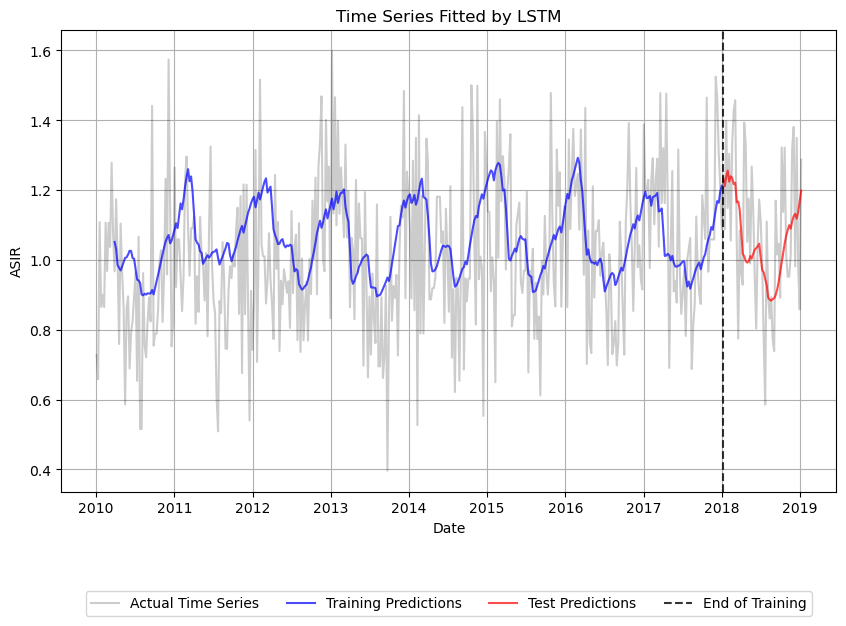

In [27]:

# Build the best model
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopper])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = target_scaler.inverse_transform(train_predict)
y_train = target_scaler.inverse_transform(y_train)
test_predict = target_scaler.inverse_transform(test_predict)
y_test = target_scaler.inverse_transform(y_test)

# Evaluate the model
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'RMSE train: {train_score}')
print(f'RMSE test: {test_score}')

# Log-likelihood, AIC, and BIC calculations
def calculate_metrics(y_true, y_pred, num_params):
    n = len(y_true)
    resid = y_true - y_pred
    sigma2 = np.var(resid)
    log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)
    
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(n) - 2 * log_likelihood
    
    return log_likelihood, aic, bic

num_params = sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
log_likelihood_train, aic_train, bic_train = calculate_metrics(y_train, train_predict, num_params)
log_likelihood_test, aic_test, bic_test = calculate_metrics(y_test, test_predict, num_params)

print(f'Log-Likelihood train: {log_likelihood_train}')
print(f'Log-Likelihood test: {log_likelihood_test}')
print(f'AIC train: {aic_train}')
print(f'AIC test: {aic_test}')
print(f'BIC train: {bic_train}')
print(f'BIC test: {bic_test}')

from statsmodels.stats.diagnostic import acorr_ljungbox
# Calculate residuals for test set
test_residuals = y_test - test_predict
print(acorr_ljungbox(test_residuals)[:1])

# Plot actual data and predictions
actual_data = np.hstack((target_scaler.inverse_transform(scaled_target), scaler.inverse_transform(scaled_features)))

train_years = original_index[seq_length:seq_length + train_index - seq_length]
test_years = original_index[seq_length + train_index - seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(original_index, actual_data[:, 0], label='Actual Time Series', color='black', alpha=0.2)
plt.plot(train_years, train_predict, label='Training Predictions', color='blue', alpha=0.7)
plt.plot(test_years, test_predict, label='Test Predictions', color='red', alpha=0.7)
plt.axvline(original_index[train_index], color='k', linestyle='--', label='End of Training', alpha = 0.8)
plt.xlabel('Date')
plt.ylabel('ASIR')
plt.title('Time Series Fitted by LSTM')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)  # ncol sets the number of columns in the legend
plt.grid(True)
plt.savefig('plots/LSTM_forecast.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Calculate evaluation metrics for LSTM
mae_lstm = mean_absolute_error(y_test, test_predict)
mse_lstm = mean_squared_error(y_test, test_predict)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_test - test_predict) / y_test)) * 100



In [28]:
# Add LSTM metrics to DataFrame
compare['lstm'] = [mae_lstm, mse_lstm, rmse_lstm, mape_lstm, aic_test, bic_test]

latex_table = compare.T.to_latex(index=False)
print(latex_table)

\begin{tabular}{llllll}
\toprule
0 & 1 & 2 & 3 & 4 & 5 \\
\midrule
MAE & MSE & RMSE & MAPE & AIC & BIC \\
0.124815 & 0.021337 & 0.146072 & 26.836396 & -329.559177 & -297.294487 \\
0.152210 & 0.033196 & 0.182197 & 14.572925 & 909871.240780 & 1806257.517142 \\
\bottomrule
\end{tabular}



# ONLY BARCELONA

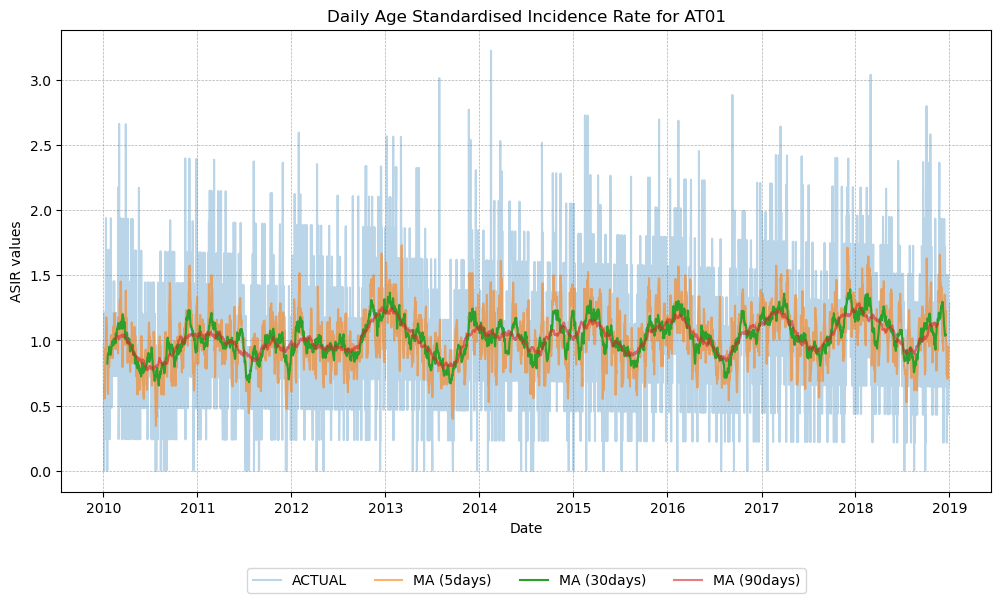

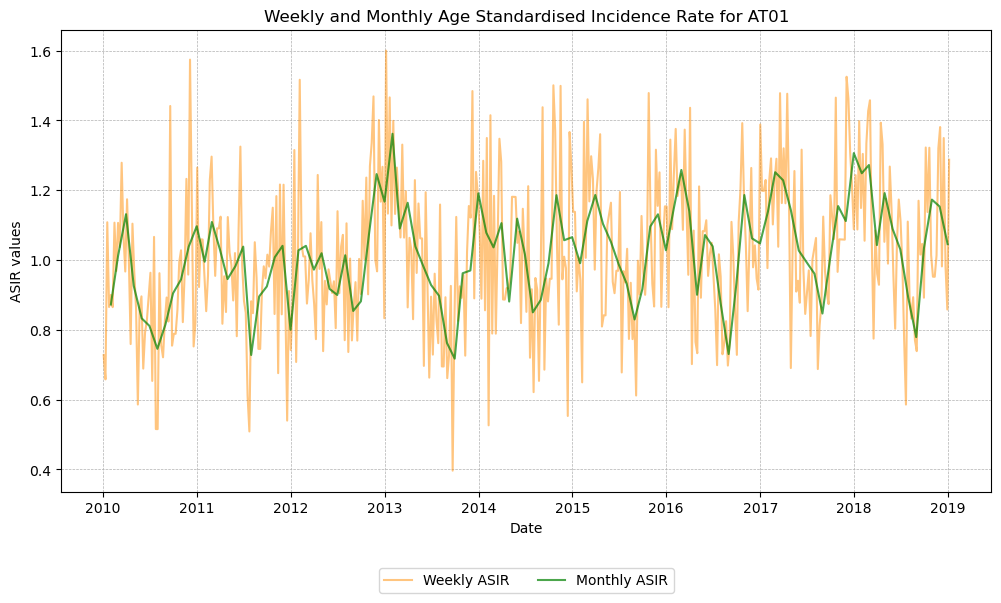

In [38]:
data = pd.read_csv('modelling_data/data.csv')
data.date = pd.to_datetime(data.date)
# Filter data for AT01 and AT03
data_at01 = data[data['at_code'] == 'AT01']


# Plotting

# Subplot for AT01
plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(data_at01['date'], data_at01['asir'], label='ACTUAL', alpha=0.3)
plt.plot(data_at01['date'], data_at01['c_asir_5'], label='MA (5days)', alpha=0.6)
plt.plot(data_at01['date'], data_at01['b_asir_30'], label='MA (30days)', alpha=1)
plt.plot(data_at01['date'], data_at01['a_asir_90'], label='MA (90days)', alpha=0.6)
#plt.plot(data_at01['date'], data_at01['b_asir_365'], label='asir_365', alpha=0.6)

plt.title('Daily Age Standardised Incidence Rate for AT01')

# Format the date axis
plt.gca().xaxis.set_major_locator(YearLocator(1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().grid(which='major', linestyle='--', linewidth=0.5)  # Major grid style

# Create a single legend for the plot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Set common labels
plt.xlabel('Date')
plt.ylabel('ASIR values')

# Save the plot as a PDF file
plt.savefig('plots/asir_plots_daily.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

# Filter data for AT01 and AT03
data_at01 = data[data['at_code'] == 'AT01'][['date', 'max_hum', 'min_hum', 'max_temp', 'min_temp','a_asir_90', 'b_asir_365', 'c_asir_5', 'b_asir_30', 'asir', 'is_holiday', 'mean_O3', 'mean_PM10']]

# Define custom aggregation functions
custom_agg_functions = {
    'max_hum': 'max',
    'min_hum': 'min',
    'max_temp': 'max',
    'min_temp': 'min',
    'a_asir_90': 'mean',
    'b_asir_365': 'mean',
    'c_asir_5': 'mean',
    'b_asir_30': 'mean',
    'asir': 'mean',
    'is_holiday': 'max',
    'mean_O3' : 'mean',
    'mean_PM10' : 'mean'
}

# Aggregate data to weekly values
data_at01_weekly = data_at01.resample('W', on='date').agg(custom_agg_functions)
data_at01_monthly = data_at01.resample('M', on='date').agg(custom_agg_functions)

# Plotting both weekly and monthly aggregated 'asir'
plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(data_at01_weekly.index, data_at01_weekly['asir'], label='Weekly ASIR', alpha=0.5, color = 'darkorange')
plt.plot(data_at01_monthly.index, data_at01_monthly['asir'], label='Monthly ASIR', alpha=0.7, color = 'green')

plt.title('Weekly and Monthly Age Standardised Incidence Rate for AT01')
plt.xlabel('Date')
plt.ylabel('ASIR values')
plt.gca().xaxis.set_major_locator(YearLocator(1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().grid(which='major', linestyle='--', linewidth=0.5)

# Create legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
# Save the plot as a PDF file
plt.savefig('plots/weekly_monthly_asir.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

